In [65]:
# Importing all the necessary libraries
# Transformers library provides pre-trained models and tokenizers for NLP tasks
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup

# PyTorch is a machine learning library used for building neural networks
import torch
import torch.nn as nn  # nn module contains useful classes to build neural networks

# DataLoader helps manage data in batches, making it easier to work with large datasets
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# AdamW is an optimizer for updating model parameters during training
from torch.optim import AdamW

# Pandas is a data manipulation library for working with structured data (like tables)
import pandas as pd

# Preprocess is a custom module for cleaning and preparing text data
import preprocess

# NumPy is a library for numerical operations and handling arrays
import numpy as np


In [66]:
# Loading and processing dataset
data = pd.read_csv('train/stock_data.csv')

In [67]:
# Display first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
                                                Text  Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1  user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2  user I'd be afraid to short AMZN - they are lo...          1
3                                  MNTA Over 12.00            1
4                                   OI  Over 21.37            1


In [68]:
# Display dataset information (data types, null values, etc.)
print("\nDataset Information:")
print(data.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB
None


In [69]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Text         0
Sentiment    0
dtype: int64


In [70]:
# Handle missing values if any (optional, depends on dataset)
# For example, dropping rows with missing values:
data = data.dropna()

# Descriptive statistics of the dataset
print("\nDescriptive statistics:")
print(data.describe())


Descriptive statistics:
         Sentiment
count  5791.000000
mean      0.272664
std       0.962192
min      -1.000000
25%      -1.000000
50%       1.000000
75%       1.000000
max       1.000000


In [71]:
# Check for class imbalance in sentiment labels
sentiment_counts = data['Sentiment'].value_counts()
print("\nSentiment label distribution:")
print(sentiment_counts)



Sentiment label distribution:
 1    3685
-1    2106
Name: Sentiment, dtype: int64


In [72]:
# Process the Tweets for NLP
# The Preprocess_Tweets function from the 'preprocess' module is called to clean and prepare the tweet data

data = preprocess.Preprocess_Tweets(data)  # Call the preprocessing function on the raw tweet data

# Display the processed data
# This will show the first few rows of the cleaned tweet data, allowing us to verify that the preprocessing
# steps have been applied correctly. It's important to check that the text is now formatted properly for
# further analysis and model training.
display(data)

,Text,Sentiment,Text_Cleaned
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kickers on my watchlist xide tit soq pnk cpw b...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,aap movie 55 percent return for the fea and ge...
2,user I'd be afraid to short AMZN - they are lo...,1,id be afraid to short amzn to they are looking...
3,MNTA Over 12.00,1,mnta over 12.00
4,OI Over 21.37,1,oi over 21.37
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,-1,industry body cii said are likely to suffer a ...
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1,prices slip below rs 46000 as book profits ami...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,workers at bajaj auto have agreed to a 10 perc...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,live sensex off day’s high up 600 points tests...


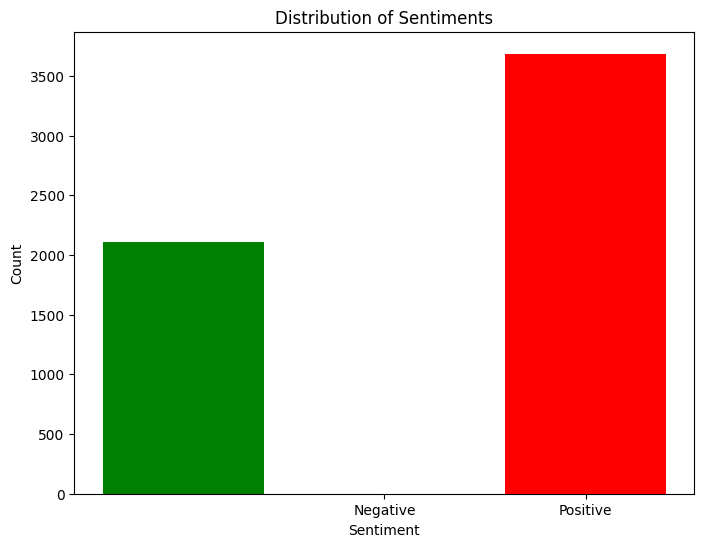

In [73]:
### Graphical Enhancements ###
# Sentiment distribution as a bar chart (as done earlier)
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

In [77]:
# Split the training and test data into an 80/20 split
# This means we will use 80% of the data for training the model and 20% for testing its performance.

train_pct = 0.8  # Set the percentage of data to be used for training

# Set a random seed for reproducibility
# This ensures that every time we run this code, we get the same random results.
# It is particularly useful for debugging and comparing results.
np.random.seed(1)

# Create a random permutation of indices for the dataset
# This randomly shuffles the indices of the data, allowing us to split the data
# into training and test sets in a random manner, which helps ensure that 
# the training and test sets are representative of the overall data distribution.
idx = np.random.permutation(len(data))  # Generate a random permutation of indices based on the length of the data
print(idx)

[1812 2928 1412 ... 3980  235 5157]


Model Training and Fitting

In [78]:
X_train = data['Text_Cleaned'].values[idx[:int(train_pct*len(data))]]
y_train = data['Sentiment'].values[idx[:int(train_pct*len(data))]]
y_train[y_train==-1] = 0


X_test = data['Text_Cleaned'].values[idx[int(train_pct*len(data)):]]
y_test = data['Sentiment'].values[idx[int(train_pct*len(data)):]]
y_test[y_test==-1] = 0

In [79]:
print(X_train.shape, y_train.shape )
print(X_test.shape, y_test.shape )

(4632,) (4632,)
(1159,) (1159,)


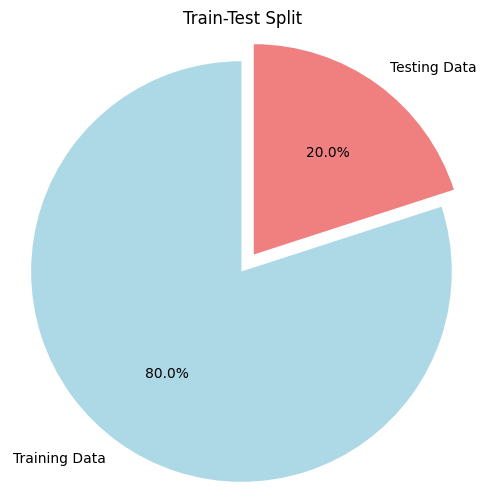

In [80]:

train_size = len(X_train)  
test_size = len(X_test)    

# Create a pie chart to visualize the train-test split
plt.figure(figsize=(6, 6))
sizes = [train_size, test_size]
labels = ['Training Data', 'Testing Data']
colors = ['lightblue', 'lightcoral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.1, 0))  # explode to highlight
plt.title('Train-Test Split')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()

Tokenization

In [58]:
# The BERT tokenizer is responsible for converting the raw text of the tweets
# into a format that the BERT model can understand. This includes:
# - Tokenizing the text: Breaking down the text into smaller components, such as words or subwords.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  
# Load the pre-trained BERT tokenizer
# (it converts all text to lowercase).

Encoding Tweets for Model

In [81]:
import torch

# Define the maximum length for BERT input
MAX_LEN = 128  # You can adjust this as needed

# Encode the tweets for the BERT model
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []
    
    # For each tweet
    for line in data:
        # Encode the data. Return input encoding and attention mask
        encoding = tokenizer.encode_plus(
            text=line,                # Data to process
            add_special_tokens=True,  # Adds special chars [CLS] and [SEP] to encoding
            padding='max_length',     # Pad the tweets with 0s to fit max length
            max_length=MAX_LEN,       # Assign max length
            truncation=True,          # Truncate tweets longer than max length
            return_tensors="pt",     # Return tensor as PyTorch tensor
            return_attention_mask=True # Return the attention mask
        )

        # Add the encodings to the list
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
        
    # Return the lists as tensors
    input_ids = torch.cat(input_ids, dim=0)  # Concatenate along the first dimension
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks


In [82]:
# Use this to determine max length for encoding
encoded = [tokenizer.encode(sent, add_special_tokens=True) for sent in data['Text_Cleaned'].values]
MAX_LEN = max([len(sent) for sent in encoded])
print('Max length: ', MAX_LEN)

Max length:  53
